In [13]:


from DataAnalysisClass import *
from clustering_work import *
from quantumresponsepro import BasisMRADataAnalyzer

single = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV5Z', 'aug-cc-pV6Z']
single_polarized = ['aug-cc-pCVDZ', 'aug-cc-pCVTZ', 'aug-cc-pCVQZ']
double = ['d-aug-cc-pVDZ', 'd-aug-cc-pVTZ', 'd-aug-cc-pVQZ', 'd-aug-cc-pV5Z', 'd-aug-cc-pV6Z']
double_polarized = ['d-aug-cc-pCVDZ', 'd-aug-cc-pCVTZ', 'd-aug-cc-pCVQZ']
all_basis_sets = single + single_polarized + double + double_polarized


In [40]:

database_path = Path('/mnt/data/madness_data/post_watoc/august')
paper_path = Path('/home/adrianhurtado/projects/writing/thesis2023/Figures_v2')



In [34]:
import glob

# glob for .mol files in august molecules directory
mols = glob.glob('/mnt/data/madness_data/post_watoc/august/molecules/*.mol')
# remove .mol extension
mols = [mol.split('/')[-1].split('.')[0] for mol in mols]

In [35]:
august_database = PolarizabilityData(mols, 'hf', 'dipole', all_basis_sets, database_path,
                                     overwrite=False)

analyzer = BasisMRADataAnalyzer(august_database, .02, )
polar_data = august_database.iso_data.copy()

In [53]:
# isolate the basis set data not MRA
basis_data = polar_data.query('basis!="MRA"').copy()
basis_data = basis_data.set_index(['molecule', 'omega'])
basis_data['alphaMRA'] = polar_data.query('basis=="MRA"').set_index(['molecule', 'omega'])[
    'alpha']
# do the same for gamma
basis_data['gammaMRA'] = polar_data.query('basis=="MRA"').set_index(['molecule', 'omega'])[
    'gamma']
# reset index
basis_data = basis_data.reset_index()
basis_data['alphaE'] = ((basis_data['alpha'] - basis_data['alphaMRA']) / basis_data['alpha'
                                                                                    'MRA'
                                                                                    ''] * 100)
basis_data['gammaE'] = ((basis_data['gamma'] - basis_data['gammaMRA']) / basis_data['gamma'
                                                                                    'MRA'
                                                                                    ''] * 100)
basis_data = make_detailed_df(basis_data)


def get_basis_data(basis_data, omega=8):
    df = basis_data.query('omega==@omega')
    alphab = {}
    gammab = {}
    for b in basis_data.basis.unique():
        bdata = df.query('basis==@b')
        alphab[b] = bdata.set_index('molecule').alpha
        gammab[b] = bdata.set_index('molecule').gamma
    alpha_df = pd.DataFrame(alphab)
    gamma_df = pd.DataFrame(gammab)
    return alpha_df, gamma_df


data = get_basis_data(basis_data,0)[0]
data.drop(['aug-cc-pV5Z', 'aug-cc-pV6Z', 'd-aug-cc-pV5Z', 'd-aug-cc-pV6Z'], axis=1, inplace=True)
data.dropna(inplace=True)


['D', 'T', 'Q', '5', '6']


In [54]:

def cluster_basis_data(data, n_clusters=8):
    scaler = StandardScaler()
    X = data.to_numpy()
    data_scaled = scaler.fit_transform(X)
    # Create an AgglomerativeClustering instance with n_clusters
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    # Fit the model to your data and get the cluster assignments in one step
    labels = agglo.fit_predict(data_scaled)
    data['cluster'] = labels

    return data


def inv_symlog(y, linthresh):
    """Inverse of symmetric log transformation."""
    return np.sign(y) * linthresh * (np.exp(np.abs(y)) - 1)


def symlog(x, linthresh):
    """Symmetric log transformation."""
    return np.sign(x) * np.log1p(np.abs(x / linthresh))

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
def cluster_gaussian_mixture_with_bic(data,paper_path):
    """
    Bayesian Information Criterioon (BIC) for model selction amoung a finite set of models
    Based on likelhood function and introduces a penalty term for complexity to avoid overfitting
    In this context used to select the number of clusters
    """
    scaler = StandardScaler()
    data_matrix = data.to_numpy()
    threshold = analyzer.mra_ref

    data_matrix = symlog(data_matrix, threshold)

    data_matrix = scaler.fit_transform(data_matrix)

    # pca = PCA(n_components=4)
    # principal_components = pca.fit_transform(data_matrix)

    # print(data_scaled)
    # data_matrix = principal_components

    n_clusters_range = range(1, 16)
    bic_scores = []
    convergence_type = 'full'
    tol = 1e-3

    for n_clusters in n_clusters_range:
        # Create and fit a Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=convergence_type,
                              random_state=42,
                              tol=tol, n_init=10, )
        gmm.fit(data_matrix)

        # Compute BIC for the current clustering
        bic_scores.append(gmm.bic(data_matrix))

    # Find the number of clusters that gives the minimum BIC
    optimal_clusters = n_clusters_range[np.argmin(bic_scores)]
    neigh = NearestNeighbors(n_neighbors=optimal_clusters)
    # optimal_clusters = 4
    print(f"Optimal number of clusters: {optimal_clusters}")

    plt.figure()  # Adjust the size of the plot as needed
    plt.plot(n_clusters_range, bic_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC score')
    plt.title('BIC score per number of clusters')
    plt.tight_layout()
    plt.savefig(paper_path.joinpath('BIC.svg'))
    plt.show()

    # Create an AgglomerativeClustering instance with n_clusters
    # gmm = BayesianGaussianMixture(n_components=optimal_clusters,
    #                               random_state=None,
    #                               covariance_type='full',
    #                               tol=1e-6, )
    gmm = GaussianMixture(n_components=optimal_clusters,
                          covariance_type=convergence_type,
                          random_state=42,
                          warm_start=True,
                          n_init=40,
                          tol=tol, )
    neigh.fit(data_matrix)

    # Fit the model to your data and get the cluster assignments in one step
    labels = neigh.predict(data_matrix)
    score = silhouette_score(data_matrix, labels, metric='euclidean')
    data['cluster'] = labels
    print("silhouette score", score)

    average_vectors = []
    std_vectors = []
    for i in range(optimal_clusters):
        cluster_points = data_matrix[labels == i]
        average_vector = np.mean(cluster_points, axis=0)
        std_vector = np.std(cluster_points, axis=0)
        average_vectors.append(average_vector)
        std_vectors.append(std_vector)

    avg_df = pd.DataFrame(average_vectors, )
    avg_df['mean'] = avg_df.mean(axis=1)
    avg_df = avg_df.sort_values('mean', ascending=False)
    avg_df.drop('mean', axis=1, inplace=True)

    std_df = pd.DataFrame(std_vectors, )

    sorted_index = avg_df.index
    std_df = std_df.reindex(sorted_index)
    std_df.sort_index(inplace=True)

    cluster_map = {sorted_index[i]: i for i in range(len(sorted_index))}
    avg_df = avg_df.reset_index(drop=True)
    # avg_df = avg_df.apply(lambda x: inv_symlog(x, threshold))
    # avg_df = pd.DataFrame(scaler.inverse_transform(avg_df), columns=avg_df.columns,
    #                      index=avg_df.index)
    print(cluster_map)
    data['cluster'] = data['cluster'].map(cluster_map)
    # avg_df = np.exp(avg_df) + xmin

    # Generate a line plot
    fig = plt.figure()  # Adjust the size of the plot as needed
    for i, row in avg_df.iterrows():
        plt.plot(row, label=f'Cluster {i}', marker='o')
    # plt.yscale('log')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0
    plt.xlabel('Basis set')  # Label for the x-axis
    plt.ylabel('Average basis set error')  # Label for the y-axis
    plt.title('Average basis set errors for each cluster')  # Title of the plot
    plt.legend()  # Show the legend
    plt.xticks(rotation=60)  # Rotate the x-axis labels for better visibility if needed
    plt.tight_layout()  # Adjust the layout for better visibility if needed
    plt.show()
    fig.savefig(paper_path.joinpath('GMM_averages.svg'))

    return data, avg_df




Optimal number of clusters: 2


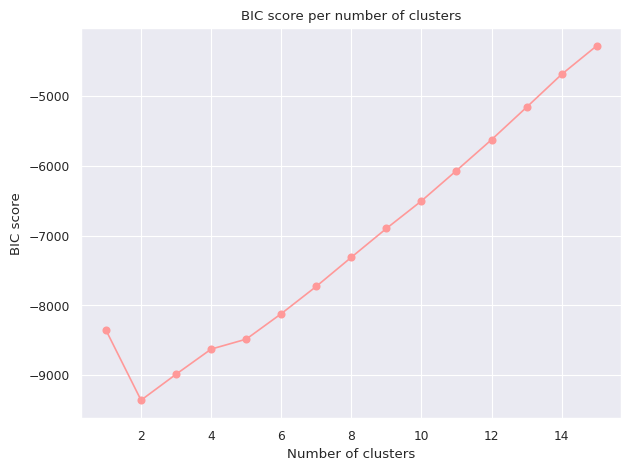

AttributeError: 'NearestNeighbors' object has no attribute 'predict'

In [52]:
omega = 8
linthresh = 1e-2
X, avg_vectors = cluster_gaussian_mixture_with_bic(data, paper_path)
avg_vectors.plot()
molecules_path = paper_path.joinpath('molecules')
cluster_path = molecules_path.joinpath(f'alpha_clusters')
if not cluster_path.exists():
    cluster_path.mkdir()
else:
    shutil.rmtree(cluster_path)
    cluster_path.mkdir()

grouped = X.groupby('cluster')
cluster_mol_path = cluster_path.joinpath(f'cluster_molecules.txt')
with open(cluster_mol_path, 'w') as f:
    for cluster_id, group in grouped:
        f.write(r'\textbf{' + f'Cluster {cluster_id + 1} ' + f'({len(group.index)})' + ':} ')
        for molecule in group.index:
            f.write("\ce{" + f"{molecule}" + "}, ")
        f.write('\n\n')

for cluster_id, group in grouped:
    cluster_mol_path = cluster_path.joinpath(f'cluster_{cluster_id + 1}_molecules.txt')

    with open(cluster_mol_path, 'w') as f:
        f.write(r'\textbf{' + f'Cluster {cluster_id + 1} ' + f'({len(group.index)})' + ':} ')
        for molecule in group.index:
            f.write("\ce{" + f"{molecule}" + "}, ")



In [19]:
iso_diff = basis_data.copy()
iso_diff['cluster'] = iso_diff['molecule'].map(X['cluster'])
iso_diff['cluster'] = iso_diff['cluster'].astype('category')
g = plot_iso_valence_cluster_convergence(iso_diff, 'alpha', ['D', 'T', 'Q'], omega,
                                         sharey=True)
for ax in g.axes_dict.values():
    ax.set_yscale('symlog', linthresh=linthresh, base=10, linscale=0.50)
    ax.axhline(-.05, color='green', linestyle='--')
    ax.axhline(.05, color='green', linestyle='--')

g.fig.savefig(cluster_path.joinpath('alpha_convergence.svg'))
g.fig.show()

g = analyzer.freq_iso_plot_cluster(iso_diff, ['D', 'T', 'Q'], 'alpha', omegas=[0, 4, 8],
                                   sharey='row')
for ax in g.axes_dict.values():
    ax.set_yscale('symlog', linthresh=linthresh, base=10, linscale=0.50)
# set_face_color_cluster(g)
# freq_inset(g, iso_diff, loc='lower right', ylims=[3, .8, .18], width='30%', height='40%',
# omega=[8])
g.fig.savefig(cluster_path.joinpath('alpha_frequency_convergence.svg'))
g.fig.show()

plt.figure()

with sns.axes_style('darkgrid'):
    p = plt.figure()
    ax = p.add_subplot(111)

    sns.histplot(iso_diff.query('omega==0 & basis =="aug-cc-pVQZ"'), x="cluster",
                 hue="mol_system",
                 multiple="stack",
                 ax=ax,
                 shrink=.8)
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    p.subplots_adjust(bottom=0.2)
    plt.show()
    p.savefig(cluster_path.joinpath('cluster_molecule_count.svg'))

if True:

    for cluster in X['cluster'].unique():
        mol_list = X.query('cluster==@cluster').index
        cluster_path_i = cluster_path.joinpath(f'cluster_{cluster + 1}')
        if not cluster_path_i.exists():
            cluster_path_i.mkdir()
        else:
            shutil.rmtree(cluster_path)
            cluster_path_i.mkdir()

        for mol in mol_list:
            g = analyzer.plot_iso_valence_convergence_v2(mol, 'alpha', ['D', 'T', 'Q', '5', '6'],
                                                         omega)
            g.fig.savefig(cluster_path_i.joinpath(f'{mol}_alpha_converge.svg'), dpi=300)


[[-0.54697491 -0.55445257 -0.55711318 ... -0.55629292 -0.55861025
  -0.54641888]
 [ 0.49817049  0.50428285  0.50648321 ...  0.50572599  0.50785123
   0.52597833]
 [ 0.29436836  0.2823081   0.2793091  ...  0.28183421  0.27942555
   0.29579637]
 ...
 [-0.341955   -0.35373972 -0.35854574 ... -0.35727058 -0.36107498
  -0.34762956]
 [-0.52142292 -0.54786694 -0.55559191 ... -0.55572936 -0.55879481
  -0.54662413]
 [ 0.31367046  0.27927245  0.27245982 ...  0.28423825  0.27153303
   0.28710486]]


ValueError: Input X contains NaN.
GaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values